In [24]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import (print_function, division)
import time

import numpy as np
import matplotlib.pyplot as plt


In [34]:
"""Linear Shallow Water Model
-  Topics: geostrophic adjustment, gravity waves, Rossby Waves 
-  Original code by James Penn, modified by G. K. Valis
-  Procedural (non-object oriented) version of code

- Basic State Assumptions:
- Two dimensional (x,y,t) shallow water in a rotating frame (f≠0)
- Staggered Arakawa-C grid (see Blackboard for notes on this)
- Fixed boundary conditions in the y-dimension (free slip)
- Linearized about a fluid depth H and meanU = 0

Dimensions (SI units) are implied via values of constants e.g. Lx is
the width of the domain in metres [m], however there is no code
dependency on using specific units.  If all input values
are scaled appropriately other units may be used.

η = H + h

∂/∂t[u] - fv = - g ∂/∂x[h] + F                          (1)
∂/∂t[v] + fu = - g ∂/∂y[h] + F                          (2)
∂/∂t[h] + H(∂/∂x[u] + ∂/∂y[v]) = F                      (3)

f = f0 + βy
F is a forcing, default = (0, 0, 0)
"""

'Linear Shallow Water Model\n-  Topics: geostrophic adjustment, gravity waves, Rossby Waves \n-  Original code by James Penn, modified by G. K. Valis\n-  Procedural (non-object oriented) version of code\n\n- Basic State Assumptions:\n- Two dimensional (x,y,t) shallow water in a rotating frame (f≠0)\n- Staggered Arakawa-C grid (see Blackboard for notes on this)\n- Fixed boundary conditions in the y-dimension (free slip)\n- Linearized about a fluid depth H and meanU = 0\n\nDimensions (SI units) are implied via values of constants e.g. Lx is\nthe width of the domain in metres [m], however there is no code\ndependency on using specific units.  If all input values\nare scaled appropriately other units may be used.\n\nη = H + h\n\n∂/∂t[u] - fv = - g ∂/∂x[h] + F                          (1)\n∂/∂t[v] + fu = - g ∂/∂y[h] + F                          (2)\n∂/∂t[h] + H(∂/∂x[u] + ∂/∂y[v]) = F                      (3)\n\nf = f0 + βy\nF is a forcing, default = (0, 0, 0)\n'

In [33]:
##Section: GRID FUNCTIONS (no need to change anything)
# These functions perform calculations on the grid such as calculating
# derivatives of fields or setting boundary conditions

def update_boundaries():

    # 1. Periodic Boundaries
    #    - Flow cycles from left-right-left
    #    - u[0] == u[nx]
    if boundary_condition == 'periodic':
        _u[0, :] = _u[-3, :]
        _u[1, :] = _u[-2, :]
        _u[-1, :] = _u[2, :]
        _v[0, :] = _v[-2, :]
        _v[-1, :] = _v[1, :]
        _h[0, :] = _h[-2, :]
        _h[-1, :] = _h[1, :]


    # 2. Solid walls left and right
    #    - No zonal (u) flow through the left and right walls
    #    - Zero x-derivative in v and h
    if boundary_condition == 'walls':
        # No flow through the boundary at x=0
        _u[0, :] = 0
        _u[1, :] = 0
        _u[-1, :] = 0
        _u[-2, :] = 0

        # free-slip of other variables: zero-derivative
        _v[0, :] = _v[1, :]
        _v[-1, :] = _v[-2, :]
        _h[0, :] = _h[1, :]
        _h[-1, :] = _h[-2, :]

    # This applied for both boundary cases above
    for field in state:
        # Free-slip of all variables at the top and bottom
        field[:, 0] = field[:, 1]
        field[:, -1] = field[:, -2]

    	# fix corners to be average of neighbours
        field[0, 0] =  0.5*(field[1, 0] + field[0, 1])
        field[-1, 0] = 0.5*(field[-2, 0] + field[-1, 1])
        field[0, -1] = 0.5*(field[1, -1] + field[0, -2])
        field[-1, -1] = 0.5*(field[-1, -2] + field[-2, -1])


def diffx(psi):
    """Calculate ∂/∂x[psi] over a single grid square.

    i.e. d/dx(psi)[i,j] = (psi[i+1/2, j] - psi[i-1/2, j]) / dx

    The derivative is returned at x points at the midpoint between
    x points of the input array."""
    global dx
    return (psi[1:,:] - psi[:-1,:]) / dx

def diff2x(psi):
    """Calculate ∂2/∂x2[psi] over a single grid square.

    i.e. d2/dx2(psi)[i,j] = (psi[i+1, j] - psi[i, j] + psi[i-1, j]) / dx^2

    The derivative is returned at the same x points as the
    x points of the input array, with dimension (nx-2, ny)."""
    global dx
    return (psi[:-2, :] - 2*psi[1:-1, :] + psi[2:, :]) / dx**2

def diff2y(psi):
    """Calculate ∂2/∂y2[psi] over a single grid square.

    i.e. d2/dy2(psi)[i,j] = (psi[i, j+1] - psi[i, j] + psi[i, j-1]) / dy^2

    The derivative is returned at the same y points as the
    y points of the input array, with dimension (nx, ny-2)."""
    global dy
    return (psi[:, :-2] - 2*psi[:, 1:-1] + psi[:, 2:]) / dy**2

def diffy(psi):
    """Calculate ∂/∂y[psi] over a single grid square.

    i.e. d/dy(psi)[i,j] = (psi[i, j+1/2] - psi[i, j-1/2]) / dy

    The derivative is returned at y points at the midpoint between
    y points of the input array."""
    global dy
    return (psi[:, 1:] - psi[:,:-1]) / dy

def centre_average(phi):
    """Returns the four-point average at the centres between grid points."""
    return 0.25*(phi[:-1,:-1] + phi[:-1,1:] + phi[1:, :-1] + phi[1:,1:])

def y_average(phi):
    """Average adjacent values in the y dimension.
    If phi has shape (nx, ny), returns an array of shape (nx, ny - 1)."""
    return 0.5*(phi[:,:-1] + phi[:,1:])

def x_average(phi):
    """Average adjacent values in the x dimension.
    If phi has shape (nx, ny), returns an array of shape (nx - 1, ny)."""
    return 0.5*(phi[:-1,:] + phi[1:,:])

def divergence():
    """Returns the horizontal divergence at h points."""
    return diffx(u) + diffy(v)

def del2(phi):
    """Returns the Laplacian of phi."""
    return diff2x(phi)[:, 1:-1] + diff2y(phi)[1:-1, :]

def uvatuv():
    """Calculate the value of u at v and v at u."""
    global _u, _v
    ubar = centre_average(_u)[1:-1, :]
    vbar = centre_average(_v)[:, 1:-1]
    return ubar, vbar

def uvath():
    global u, v
    ubar = x_average(u)
    vbar = y_average(v)
    return ubar, vbar

def absmax(psi):
    return np.max(np.abs(psi))



SyntaxError: EOF while scanning triple-quoted string literal (800665211.py, line 127)

In [27]:
## Section: DYNAMICS functions (no need to change anything)
#  These functions calculate the dynamics of the system we are interested in
def forcing():
    """Add some external forcing terms to the u, v and h equations.
    This function should return a state array (du, dv, dh) that will
    be added to the RHS of equations (1), (2) and (3) when
    they are numerically integrated."""
    global u, v, h
    du = np.zeros_like(u)
    dv = np.zeros_like(v)
    dh = np.zeros_like(h)
    # Calculate some forcing terms here...
    return np.array([du, dv, dh],dtype=object)

def damping(var):
    # sponges are active at the top and bottom of the domain by applying Rayleigh friction
    # with exponential decay towards the centre of the domain
    global sponge, sponge_ny
    var_sponge = np.zeros_like(var)
    var_sponge[:, :sponge_ny] = sponge[np.newaxis, :]
    var_sponge[:, -sponge_ny:] = sponge[np.newaxis, ::-1]
    return var_sponge*var

def rhs():
    """Calculate the right hand side of the u, v and h equations."""
    u_at_v, v_at_u = uvatuv()   # (nx, ny+1), (nx+1, ny)

    # the height equation
    h_rhs = -H*divergence() + nu*del2(_h) - r*damping(h)

    # the u equation
    dhdx = diffx(_h)[:, 1:-1]  # (nx+1, ny)
    u_rhs = (f0 + beta*uy)*v_at_u - g*dhdx + nu*del2(_u) - r*damping(u)

    # the v equation
    dhdy  = diffy(_h)[1:-1, :]   # (nx, ny+1)
    v_rhs = -(f0 + beta*vy)*u_at_v - g*dhdy + nu*del2(_v) - r*damping(v)

    return np.array([u_rhs, v_rhs, h_rhs],dtype=object) + forcing()

def step():
    global dt, t, tc, _ppdstate, _pdstate

    update_boundaries()

    dstate = rhs()

    # take adams-bashforth step in time
    if tc==0:
        # forward euler
        dt1 = dt
        dt2 = 0.0
        dt3 = 0.0
    elif tc==1:
        # AB2 at step 2
        dt1 = 1.5*dt
        dt2 = -0.5*dt
        dt3 = 0.0
    else:
        # AB3 from step 3 on
        dt1 = 23./12.*dt
        dt2 = -16./12.*dt
        dt3 = 5./12.*dt

    newstate = state + dt1*dstate + dt2*_pdstate + dt3*_ppdstate
    u[:], v[:], h[:] = newstate
    _ppdstate = _pdstate
    _pdstate = dstate

    t  += dt
    tc += 1



In [28]:
## PLOTTING
# Create several functions for displaying current state of the simulation
# Only one is used at a time - this is assigned to `plot`

def plot_all(u,v,h,n):
    hmax = np.max(np.abs(h))
    plt.clf()
    plt.subplot(222)
    X, Y = np.meshgrid(ux, uy)
    plt.contourf(X/Lx, Y/Ly, u.T, cmap=plt.cm.RdBu, levels=colorlevels*absmax(u))
    plt.colorbar()
    plt.title('u')

    plt.subplot(224)
    X, Y = np.meshgrid(vx, vy)
    plt.contourf(X/Lx, Y/Ly, v.T, cmap=plt.cm.RdBu, levels=colorlevels*absmax(v))
    plt.colorbar()
    plt.title('v')

    plt.subplot(221)
    X, Y = np.meshgrid(hx, hy)
    plt.contourf(X/Lx, Y/Ly, h.T, cmap=plt.cm.RdBu, levels=colorlevels*absmax(h))
    plt.colorbar()
    plt.title('h')

    plt.subplot(223)
    plt.plot(hx/Lx, h[:, ny//2])
    plt.xlim(-0.5, 0.5)
    plt.ylim(-absmax(h), absmax(h))
    plt.title('h along x=0')
    
#    plt.savefig(f"ShallowWater_{n}.png",format='png')  ## uncomment this to save each plot as an image and ...
    plt.pause(0.001)                                    ## ... comment out these two lines to to prevent  ...
    plt.draw()                                          ## ... them from plotting directly to the notebook

def plot_fast(u,v,h):
    # only plots an imshow of h, much faster than contour maps
    global im
    if im is None:
        im = plt.imshow(h.T, aspect=Ly/Lx, cmap=plt.cm.RdBu, interpolation='bicubic')
        im.set_clim(-absmax(h), absmax(h))
    else:
        im.set_array(h.T)
        im.set_clim(-absmax(h), absmax(h))
    plt.pause(0.001)
    plt.draw()

def plot_geo_adj(u, v, h):
        plt.clf()

        h0max = absmax(h0)
        plt.subplot(311)
        plt.plot(hx, h[:, ny//2], 'b', linewidth=2)
        plt.plot(hx, h0[:], 'r--', linewidth=1,)
        plt.ylabel('height')
        plt.ylim(-h0max*1.2, h0max*1.2)

        plt.subplot(312)
        plt.plot(vx, v[:, ny//2].T, linewidth=2)
        plt.plot(vx, v0[:, ny//2], 'r--', linewidth=1,)
        plt.ylabel('v velocity')
        plt.ylim(-h0max*.12, h0max*.12)

        plt.subplot(313)
        plt.plot(ux, u[:, ny//2], linewidth=2)
        plt.plot(ux, u0[:, ny//2], 'r--', linewidth=1,)
        plt.xlabel('x/L$_\mathsf{d}$',size=16)
        plt.ylabel('u velocity')
        plt.ylim(-h0max*.12, h0max*.12)

        # plt.savefig(f"ShallowWater_{n}.png",format='png')   ## uncomment this to save each plot as an image and ...
        plt.pause(0.001)                                      ## ... comment out these two lines to to prevent  ...
        plt.draw()                                            ## ... them from plotting directly to the notebook

In [29]:
########################################################
### This section: Pick Model Set-up and Set Constants ##
########################################################

experiment = '2d'           # set to '1d' or '2d'
plot_interval = 20          # plot every n steps - don't change

## CONFIGURATION ##

### Coriolis and Gravity ###

##### Change Coriolis to zero and see the difference!
f0 = 1.0e-4 * 1.      # [s^-1] f = f0 + beta y  
beta =  0             # or 1.5e-11  [m^-1.s^-1]
g = 1.0               # [m.s^-2]

### Domain
nx = 128
ny = 129

H  = 100.0          # [m]  Average depth of the fluid (
Lx = 2.0e7          # [m]  Zonal width of domain
Ly = 1.0e7          # [m]  Meridional height of domain

boundary_condition = 'periodic'  # pick either 'periodic' or 'walls'
if experiment == '1d':
    boundary_condition = 'walls' # has to be walls for 1D experiement

### Diffusion and Friction ###
## probably don't need to change these
nu = 5.0e4          # [m^2.s^-1] Coefficient of diffusion
r = 1.0e-4          # Rayleigh damping at top and bottom of domain

dt = 1000.0         # Timestep [s]  ##how long are we integrating?


In [30]:
### This section: GRID Set up (don't need to change anything here)
# Setup the Arakawa-C Grid:
#
# +-- v --+
# |       |    * (nx, ny)   h points at grid centres
# u   h   u    * (nx+1, ny) u points on vertical edges  (u[0] and u[nx] are boundary values)
# |       |    * (nx, ny+1) v points on horizontal edges
# +-- v --+
#
# Variables preceeded with underscore  (_u, _v, _h) include the boundary values,
# variables without (u, v, h) are a view onto only the values defined
# within the domain

_u = np.zeros((nx+3, ny+2))
_v = np.zeros((nx+2, ny+3))
_h = np.zeros((nx+2, ny+2))

u = _u[1:-1, 1:-1]               # (nx+1, ny)
v = _v[1:-1, 1:-1]               # (nx, ny+1)
h = _h[1:-1, 1:-1]               # (nx, ny)

state = np.array([u, v, h], dtype=object)

dx = Lx / nx            # [m]
dy = Ly / ny            # [m]

# positions of the value points in [m]
ux = (-Lx/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-Lx/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-Ly/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-Ly/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

hx = vx
hy = uy

t = 0.0                 # [s] Time since start of simulation
tc = 0                  # [1] Number of integration steps taken

sponge_ny = ny//7
sponge = np.exp(-np.linspace(0, 5, sponge_ny))

_ppdstate, _pdstate = 0,0

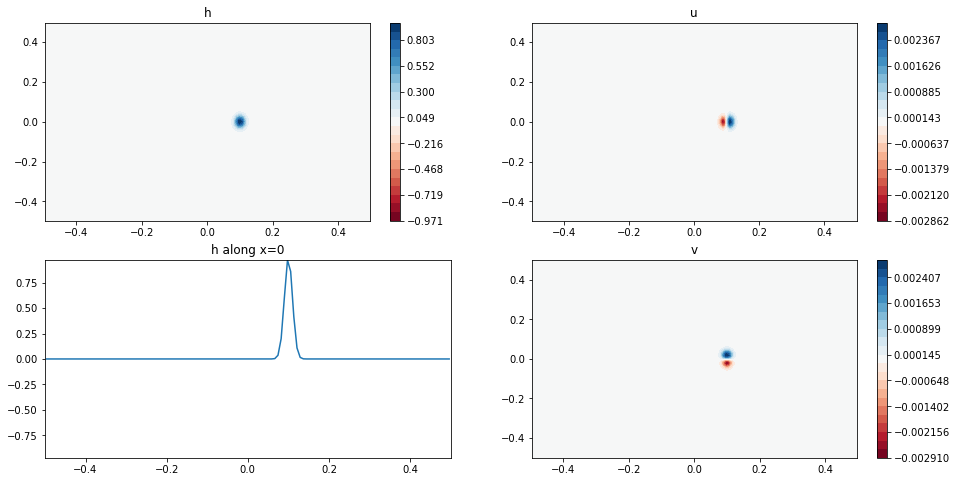

[t=   0.01 u: [-0.003, 0.003], v: [-0.003, 0.003], h: [0.000, 0.97]


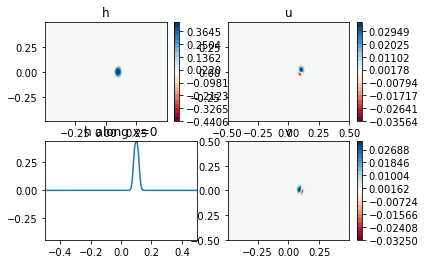

[t=   0.24 u: [-0.036, 0.034], v: [-0.031, 0.032], h: [-0.000, 0.44]


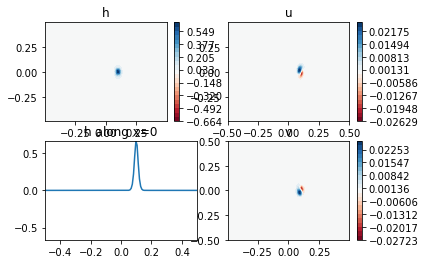

[t=   0.47 u: [-0.026, 0.025], v: [-0.027, 0.027], h: [-0.000, 0.66]


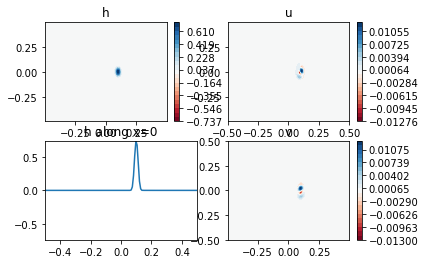

[t=   0.71 u: [-0.013, 0.013], v: [-0.012, 0.013], h: [-0.011, 0.74]


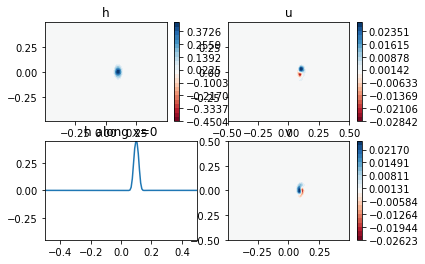

[t=   0.94 u: [-0.028, 0.028], v: [-0.026, 0.026], h: [-0.006, 0.45]


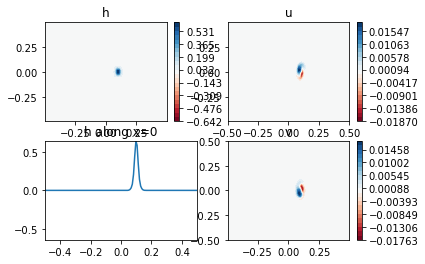

[t=   1.17 u: [-0.019, 0.017], v: [-0.017, 0.018], h: [-0.001, 0.64]


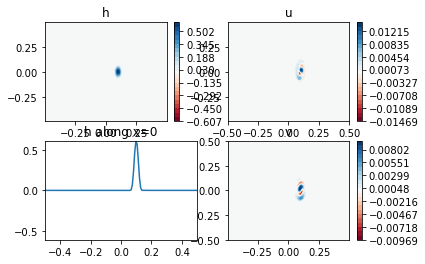

[t=   1.40 u: [-0.015, 0.014], v: [-0.010, 0.010], h: [-0.026, 0.61]


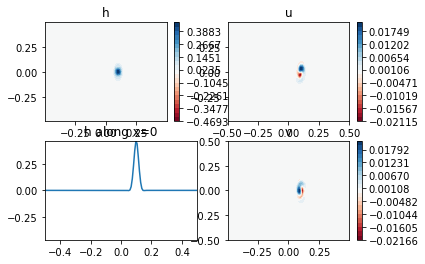

[t=   1.63 u: [-0.021, 0.021], v: [-0.022, 0.021], h: [-0.013, 0.47]


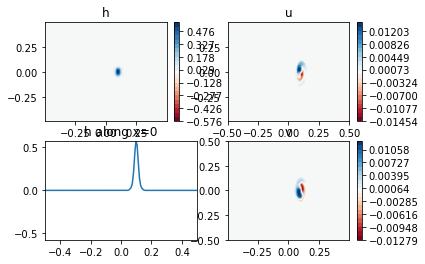

[t=   1.86 u: [-0.015, 0.014], v: [-0.013, 0.013], h: [-0.017, 0.58]


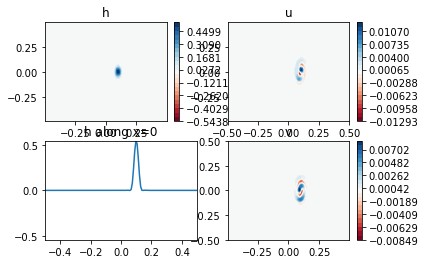

[t=   2.09 u: [-0.013, 0.012], v: [-0.008, 0.008], h: [-0.029, 0.54]


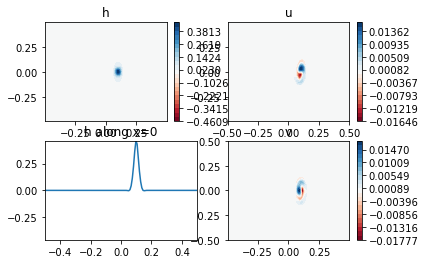

[t=   2.33 u: [-0.016, 0.016], v: [-0.018, 0.017], h: [-0.017, 0.46]


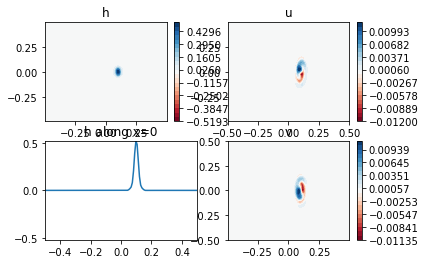

[t=   2.56 u: [-0.012, 0.012], v: [-0.011, 0.011], h: [-0.018, 0.52]


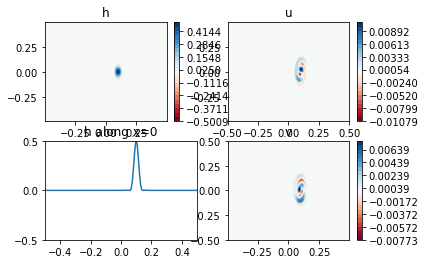

[t=   2.79 u: [-0.011, 0.010], v: [-0.007, 0.008], h: [-0.026, 0.50]


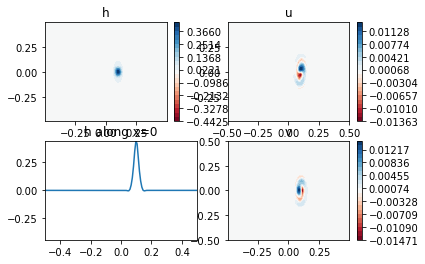

[t=   3.02 u: [-0.013, 0.014], v: [-0.015, 0.014], h: [-0.017, 0.44]


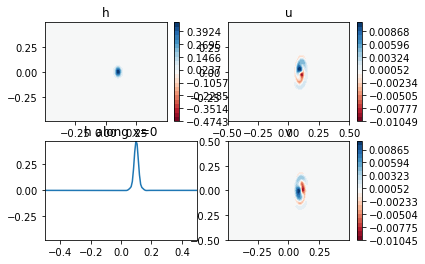

[t=   3.25 u: [-0.010, 0.010], v: [-0.010, 0.010], h: [-0.014, 0.47]


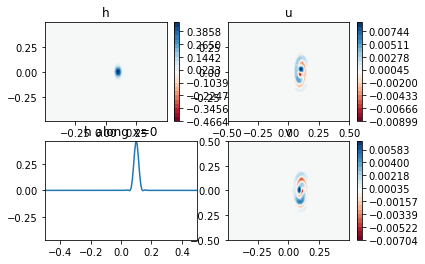

[t=   3.48 u: [-0.009, 0.009], v: [-0.007, 0.007], h: [-0.021, 0.47]


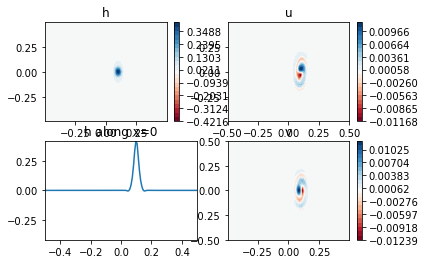

[t=   3.72 u: [-0.011, 0.012], v: [-0.012, 0.012], h: [-0.016, 0.42]


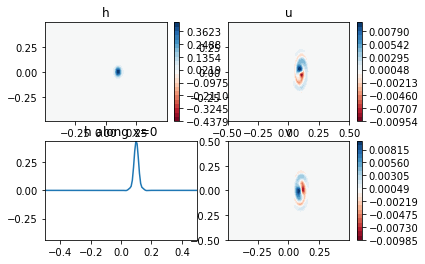

[t=   3.95 u: [-0.009, 0.010], v: [-0.010, 0.010], h: [-0.011, 0.44]


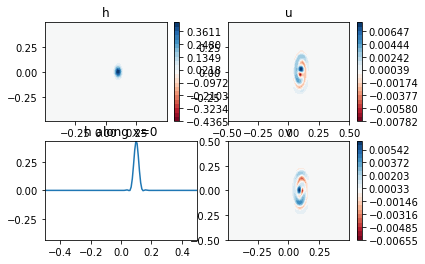

[t=   4.18 u: [-0.008, 0.008], v: [-0.007, 0.006], h: [-0.017, 0.44]


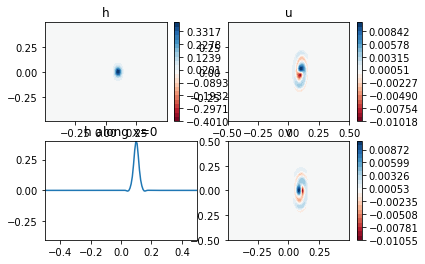

[t=   4.41 u: [-0.010, 0.010], v: [-0.011, 0.010], h: [-0.014, 0.40]


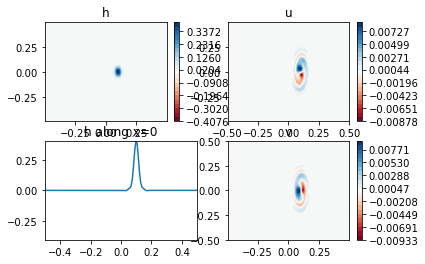

[t=   4.64 u: [-0.009, 0.009], v: [-0.009, 0.009], h: [-0.010, 0.41]


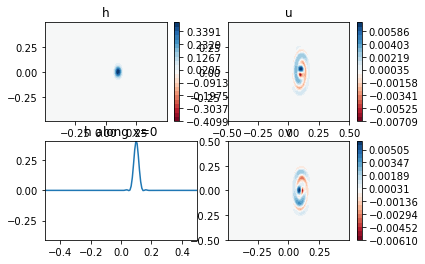

[t=   4.87 u: [-0.007, 0.007], v: [-0.006, 0.006], h: [-0.013, 0.41]


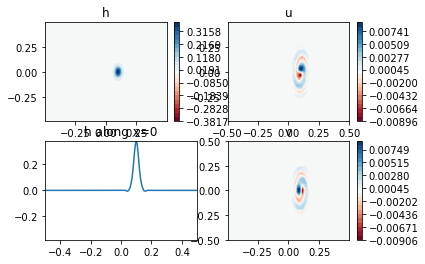

[t=   5.10 u: [-0.009, 0.009], v: [-0.009, 0.009], h: [-0.012, 0.38]


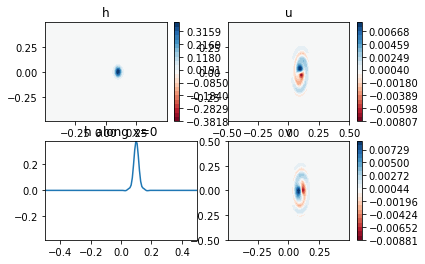

[t=   5.34 u: [-0.008, 0.008], v: [-0.008, 0.009], h: [-0.009, 0.38]


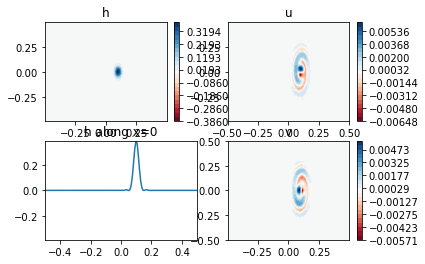

[t=   5.57 u: [-0.006, 0.006], v: [-0.006, 0.005], h: [-0.011, 0.39]


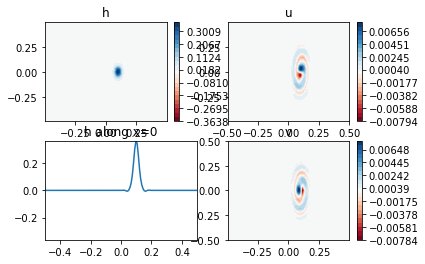

[t=   5.80 u: [-0.008, 0.008], v: [-0.008, 0.008], h: [-0.010, 0.36]


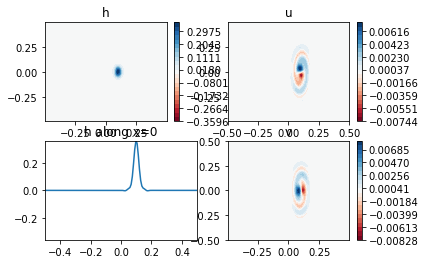

[t=   6.03 u: [-0.007, 0.007], v: [-0.008, 0.008], h: [-0.009, 0.36]


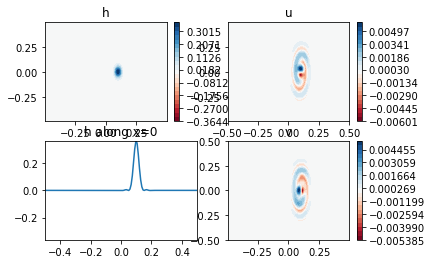

[t=   6.26 u: [-0.006, 0.006], v: [-0.005, 0.005], h: [-0.008, 0.36]


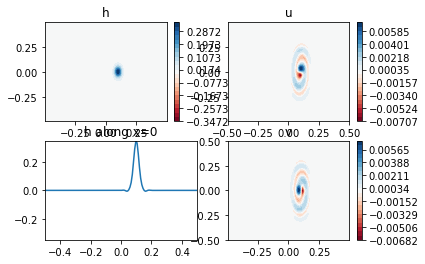

[t=   6.49 u: [-0.007, 0.007], v: [-0.007, 0.007], h: [-0.009, 0.35]


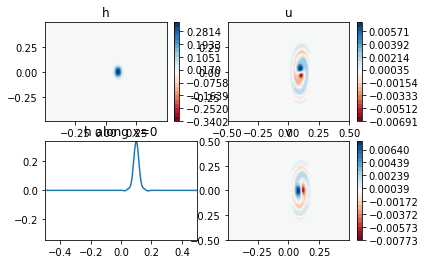

[t=   6.72 u: [-0.007, 0.007], v: [-0.008, 0.008], h: [-0.008, 0.34]


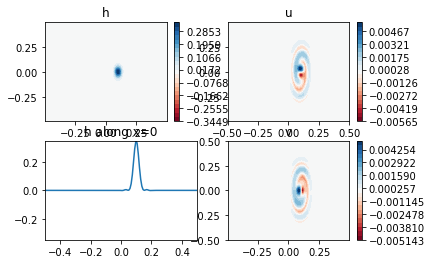

[t=   6.96 u: [-0.006, 0.006], v: [-0.005, 0.005], h: [-0.007, 0.34]


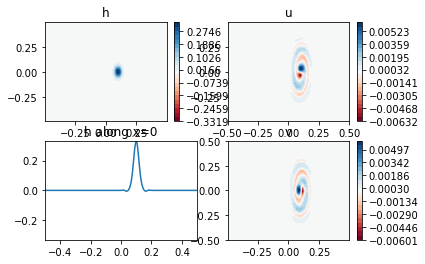

[t=   7.19 u: [-0.006, 0.006], v: [-0.006, 0.006], h: [-0.007, 0.33]


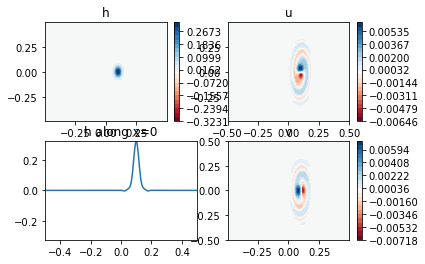

[t=   7.42 u: [-0.006, 0.006], v: [-0.007, 0.007], h: [-0.007, 0.32]


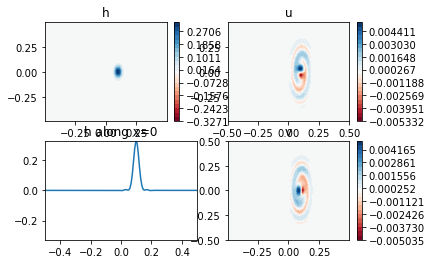

[t=   7.65 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.006, 0.33]


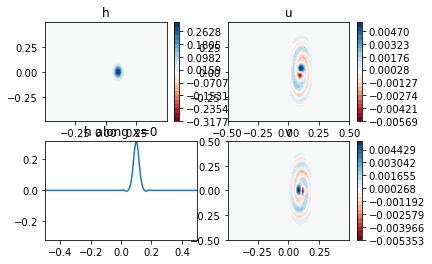

[t=   7.88 u: [-0.006, 0.006], v: [-0.005, 0.005], h: [-0.006, 0.32]


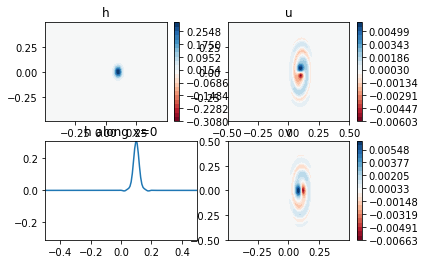

[t=   8.11 u: [-0.006, 0.006], v: [-0.007, 0.007], h: [-0.006, 0.31]


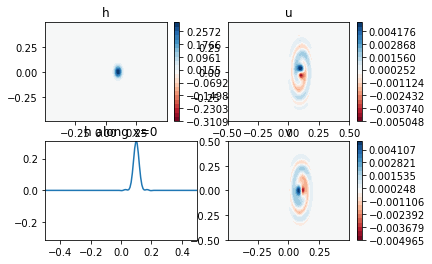

[t=   8.34 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.005, 0.31]


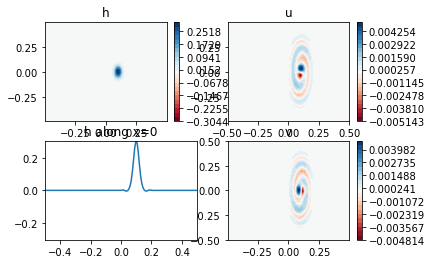

[t=   8.58 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.005, 0.30]


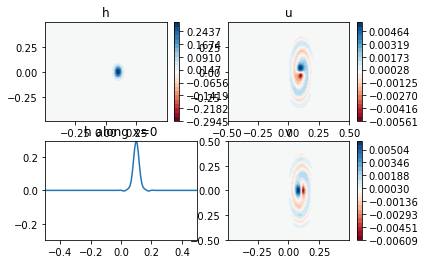

[t=   8.81 u: [-0.006, 0.006], v: [-0.006, 0.006], h: [-0.005, 0.29]


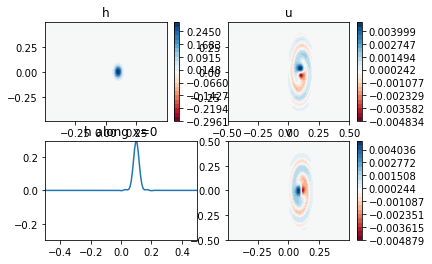

[t=   9.04 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.005, 0.30]


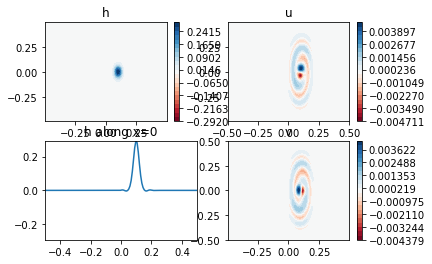

[t=   9.27 u: [-0.005, 0.005], v: [-0.004, 0.004], h: [-0.005, 0.29]


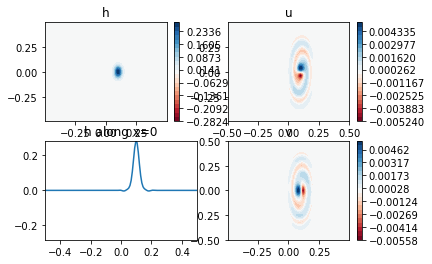

[t=   9.50 u: [-0.005, 0.005], v: [-0.006, 0.006], h: [-0.005, 0.28]


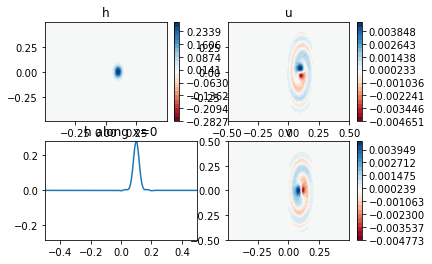

[t=   9.73 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.004, 0.28]


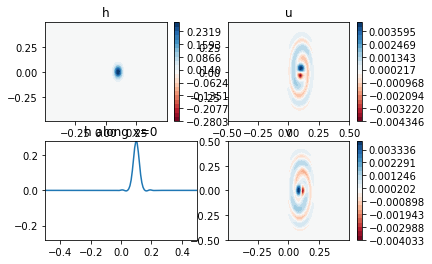

[t=   9.97 u: [-0.004, 0.004], v: [-0.004, 0.004], h: [-0.004, 0.28]


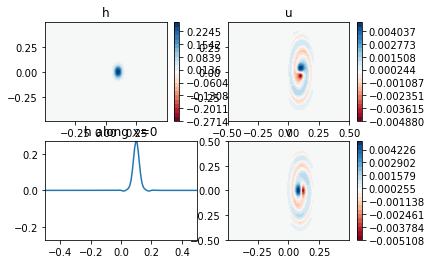

[t=  10.20 u: [-0.005, 0.005], v: [-0.005, 0.005], h: [-0.004, 0.27]


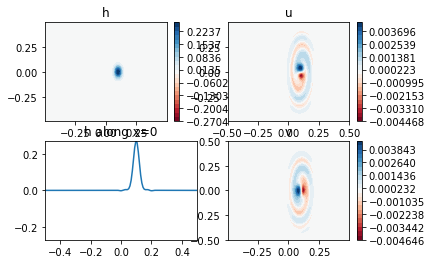

[t=  10.43 u: [-0.004, 0.004], v: [-0.005, 0.005], h: [-0.004, 0.27]


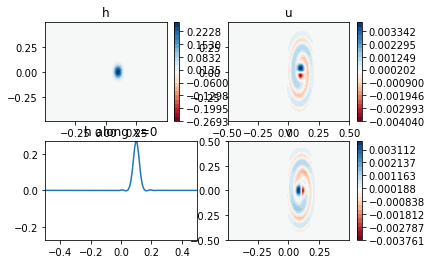

[t=  10.66 u: [-0.004, 0.004], v: [-0.004, 0.004], h: [-0.003, 0.27]


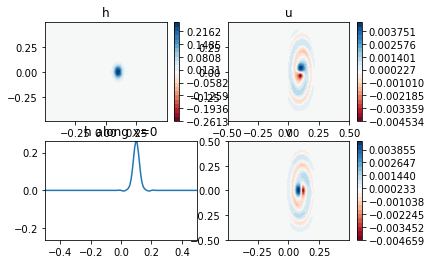

[t=  10.89 u: [-0.004, 0.005], v: [-0.005, 0.005], h: [-0.004, 0.26]


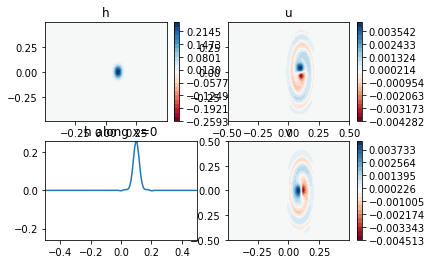

[t=  11.12 u: [-0.004, 0.004], v: [-0.005, 0.004], h: [-0.004, 0.26]


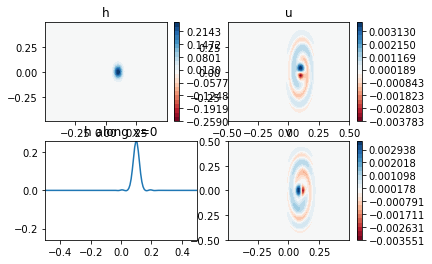

[t=  11.35 u: [-0.004, 0.004], v: [-0.003, 0.004], h: [-0.003, 0.26]


<Figure size 432x288 with 0 Axes>

In [31]:
### Run the code

## First INITIAL CONDITIONS
# Set the initial state of the model here by assigning to u[:], v[:] and h[:].
if experiment == '2d':
    # create a single disturbance in the domain:
    # a gaussian at position gx, gy, with radius gr
    gx =  2.0e6    # location in x
    gy =  0.0      # location in y
    gr =  2.0e5    # radius of distrurbace
    h0 = np.exp(-((hx - gx)**2 + (hy - gy)**2)/(2*gr**2))*H*0.01   #  initial height field
    u0 = u * 0.0    # initial u
    v0 = v * 0.0    # initial v

if experiment == '1d':
    h0 = np.cos(3.14159*hx/Lx)**n          #-np.tanh(100*hx/Lx)  #  initial height field
    v0 = v * 0.0
    u0 = u * 0.0
    # no damping in y direction
    r = 0.0

# set the variable fields to the initial conditions
u[:] = u0
v[:] = v0
h[:] = h0

## Start setting up plot info
# Create several functions for displaying current state of the simulation
# Only one is used at a time - this is assigned to `plot`
plt.ion()                         # allow realtime updates to plots
fig = plt.figure(figsize=(8*Lx/Ly, 8))  


# create a set of color levels with a slightly larger neutral zone about 0
nc = 12
colorlevels = np.concatenate([np.linspace(-1, -.05, nc), np.linspace(.05, 1, nc)])

im = None

plot = plot_all
if experiment == '1d':
    plot = plot_geo_adj


## RUN
# Run the simulation and plot the state
c = time.perf_counter() 
nsteps = 1000
n = 0
for i in range(nsteps):
    step()
    if i % plot_interval == 0:
        n = n+1
        if experiment == '1d':
            plot(*state)
        if experiment == '2d':
            plot(*state,n)
        print('[t={:7.2f} u: [{:.3f}, {:.3f}], v: [{:.3f}, {:.3f}], h: [{:.3f}, {:.2f}]'.format(
            t/86400,
            u.min(), u.max(),
            v.min(), v.max(),
            h.min(), h.max()))
        
        #print('fps: %r' % (tc / (time.clock()-c)))